In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
val_data = np.load(os.path.join(data_dir, 'validation_data.npz'))
test_data = np.load(os.path.join(data_dir, 'test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443),
 (36805,),
 (4293, 25443),
 (4293,),
 (4815, 25443),
 (4815,),
 (16, 2))

In [6]:
def preprocess(x_data):
    x_data = np.reshape(x_data, [x_data.shape[0], 99, 257, 1])
    x_data = np.rot90(x_data, 1, (1, 2))
    return x_data

In [7]:
output_size = y_table.shape[0]

In [8]:
x_train_2d = preprocess(x_train)
mean_vals = np.mean(x_train_2d, axis=0)
std_val = np.std(x_train_2d)
x_train_2d_norm = (x_train_2d-mean_vals) / std_val
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_2d = preprocess(x_val)
x_val_2d_norm = (x_val_2d-mean_vals) / std_val
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_2d = preprocess(x_test)
x_test_2d_norm = (x_test_2d-mean_vals) / std_val
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
input_shape = x_test_2d_norm[0].shape

In [11]:
def build_cnn_no_DO(conv_num=1, fcn_num=1):
    model=Sequential()
    model.add(Conv2D (kernel_size=5, filters=8, strides=(1,1), padding='valid', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv2D (kernel_size=5, filters=8*(2**(i+1)), strides=(1,1), padding='valid', 
                          activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))

    model.add(Flatten())
    
    for i in range(fcn_num):
        model.add(Dense( 1024/(2**i), activation='relu' ))
#         model.add(Dropout(0.5))
    
    model.add(Dense(output_size, activation='softmax' ))
    return model

In [12]:
# for i in range(1, 5):
#     for j in range(1, 3):
#         print(i, j)
#         model = build_cnn(conv_num=i, fcn_num=j)
#         model.summary()
#         del model

Instructions for updating:
Colocations handled automatically by placer.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.1977 - acc: 0.6268
Epoch 00001: val_loss improved from inf to 0.83149, saving model to model/checkpoint/2D_CNN_1_conv_1_fcn_no_DO_checkpoint/01-0.8315.hdf5
36805/36805 [==============================] - 23s 617us/sample - loss: 1.1976 - acc: 0.6268 - val_loss: 0.8315 - val_acc: 0.7526
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.6078 - acc: 0.8140
Epoch 00002: val_loss improved from 0.83149 to 0.67444, saving model to model/checkpoint/2D_CNN_1_conv_1_fcn_no_DO_checkpoint/02-0.6744.hdf5
36805/36805 [==============================] - 21s 569us/sample - loss: 0.6078 - acc: 0.8140 - val_loss: 0.6744 - val_acc: 0.7943
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.3894 - acc: 0.8838
Epoch

36800/36805 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9942
Epoch 00027: val_loss did not improve from 0.56429
36805/36805 [==============================] - 20s 555us/sample - loss: 0.0257 - acc: 0.9942 - val_loss: 0.8023 - val_acc: 0.8591
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0170 - acc: 0.9964
Epoch 00028: val_loss did not improve from 0.56429
36805/36805 [==============================] - 20s 556us/sample - loss: 0.0170 - acc: 0.9964 - val_loss: 0.7602 - val_acc: 0.8684
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0065 - acc: 0.9986
Epoch 00029: val_loss did not improve from 0.56429
36805/36805 [==============================] - 20s 554us/sample - loss: 0.0065 - acc: 0.9986 - val_loss: 0.8046 - val_acc: 0.8647
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9967
Epoch 00030: val_loss did not improve from 0.56429
36805/36805 [==================

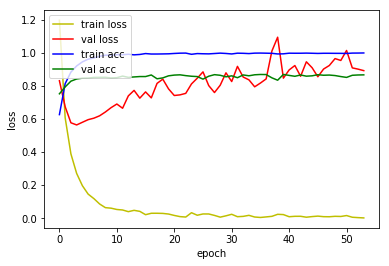

4815/4815 [==============================] - 1s 227us/sample - loss: 0.6420 - acc: 0.8181
Loss: 0.6419555853460437 Accuracy: 0.81806856

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.1474 - acc: 0.6387
Epoch 00001: val_loss improved from inf to 0.74062, saving model to model/checkpoint/2D_CNN_1_conv_2_fcn_no_DO_checkpoint/01-0.7406.hdf5
36805/36805 [==============================] - 22s 592us/sample - loss: 1.1474 - acc: 0.6387 - val_loss: 0.7406 - val_acc: 0.7666
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.5571 - acc: 0.8241
Epoch 00002: val_loss improved from 0.74062 to 0.61958, saving model to model/checkpoint/2D_CNN_1_conv_2_fcn_no_DO_checkpoint/02-0.6196.hdf5
36805/36805 [==============================] - 21s 578us/sample - loss: 0.5571 - acc: 0.8241 - val_loss: 0.6196 - val_acc: 0.8188
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.3524 - 

Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9976
Epoch 00029: val_loss did not improve from 0.51836
36805/36805 [==============================] - 21s 559us/sample - loss: 0.0093 - acc: 0.9976 - val_loss: 0.8112 - val_acc: 0.8751
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0237 - acc: 0.9939
Epoch 00030: val_loss did not improve from 0.51836
36805/36805 [==============================] - 21s 567us/sample - loss: 0.0238 - acc: 0.9939 - val_loss: 0.8109 - val_acc: 0.8682
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9926
Epoch 00031: val_loss did not improve from 0.51836
36805/36805 [==============================] - 21s 562us/sample - loss: 0.0301 - acc: 0.9926 - val_loss: 0.8579 - val_acc: 0.8644
Epoch 32/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0153 - acc: 0.9966
Epoch 00032: val_loss did not improve from 0.51836
36805/36805 [=====

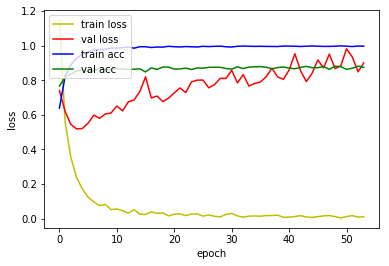

4815/4815 [==============================] - 1s 242us/sample - loss: 0.6491 - acc: 0.8160
Loss: 0.6491112678345614 Accuracy: 0.8159917

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.0928 - acc: 0.6704
Epoch 00001: val_loss improved from inf to 0.67471, saving model to model/checkpoint/2D_CNN_2_conv_1_fcn_no_DO_checkpoint/01-0.6747.hdf5
36805/36805 [==============================] - 17s 464us/sample - loss: 1.0927 - acc: 0.6705 - val_loss: 0.6747 - val_acc: 0.8020
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.4852 - acc: 0.8560
Epoch 00002: val_loss improved from 0.67471 to 0.47990, saving model to model/checkpoint/2D_CNN_2_conv_1_fcn_no_DO_checkpoint/02-0.4799.hdf5
36805/36805 [==============================] - 16s 423us/sample - loss: 0.4849 - acc: 0.8561 - val_loss: 0.4799 - val_acc: 0.8605
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2873 - a

36800/36805 [============================>.] - ETA: 0s - loss: 0.0105 - acc: 0.9968
Epoch 00028: val_loss did not improve from 0.42767
36805/36805 [==============================] - 15s 397us/sample - loss: 0.0105 - acc: 0.9968 - val_loss: 0.5734 - val_acc: 0.9094
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.9965
Epoch 00029: val_loss did not improve from 0.42767
36805/36805 [==============================] - 15s 418us/sample - loss: 0.0154 - acc: 0.9965 - val_loss: 0.5982 - val_acc: 0.9017
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9958
Epoch 00030: val_loss did not improve from 0.42767
36805/36805 [==============================] - 15s 407us/sample - loss: 0.0158 - acc: 0.9958 - val_loss: 0.5521 - val_acc: 0.9087
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.9988
Epoch 00031: val_loss did not improve from 0.42767
36805/36805 [==================

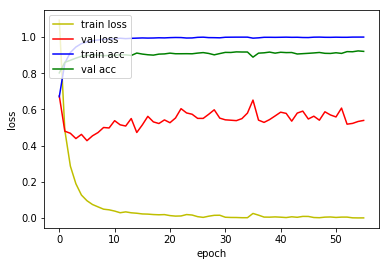

4815/4815 [==============================] - 1s 247us/sample - loss: 0.5696 - acc: 0.8604
Loss: 0.5695547017476764 Accuracy: 0.86043614

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.0915 - acc: 0.6594
Epoch 00001: val_loss improved from inf to 0.63397, saving model to model/checkpoint/2D_CNN_2_conv_2_fcn_no_DO_checkpoint/01-0.6340.hdf5
36805/36805 [==============================] - 18s 492us/sample - loss: 1.0908 - acc: 0.6595 - val_loss: 0.6340 - val_acc: 0.8092
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.5045 - acc: 0.8421
Epoch 00002: val_loss improved from 0.63397 to 0.45752, saving model to model/checkpoint/2D_CNN_2_conv_2_fcn_no_DO_checkpoint/02-0.4575.hdf5
36805/36805 [==============================] - 16s 430us/sample - loss: 0.5044 - acc: 0.8422 - val_loss: 0.4575 - val_acc: 0.8684
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.3094 - 

Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0421 - acc: 0.9874
Epoch 00029: val_loss did not improve from 0.40290
36805/36805 [==============================] - 15s 412us/sample - loss: 0.0421 - acc: 0.9874 - val_loss: 0.5239 - val_acc: 0.9026
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9955
Epoch 00030: val_loss did not improve from 0.40290
36805/36805 [==============================] - 15s 417us/sample - loss: 0.0144 - acc: 0.9955 - val_loss: 0.4954 - val_acc: 0.9094
Epoch 31/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9975
Epoch 00031: val_loss did not improve from 0.40290
36805/36805 [==============================] - 16s 425us/sample - loss: 0.0090 - acc: 0.9975 - val_loss: 0.5234 - val_acc: 0.9108
Epoch 32/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0083 - acc: 0.9980
Epoch 00032: val_loss did not improve from 0.40290
36805/36805 [=====

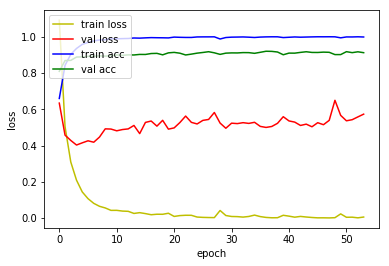

4815/4815 [==============================] - 1s 252us/sample - loss: 0.4747 - acc: 0.8563
Loss: 0.4747432759803404 Accuracy: 0.8562825

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.0537 - acc: 0.6895
Epoch 00001: val_loss improved from inf to 0.60738, saving model to model/checkpoint/2D_CNN_3_conv_1_fcn_no_DO_checkpoint/01-0.6074.hdf5
36805/36805 [==============================] - 15s 414us/sample - loss: 1.0529 - acc: 0.6897 - val_loss: 0.6074 - val_acc: 0.8297
Epoch 2/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.4611 - acc: 0.8628
Epoch 00002: val_loss improved from 0.60738 to 0.43619, saving model to model/checkpoint/2D_CNN_3_conv_1_fcn_no_DO_checkpoint/02-0.4362.hdf5
36805/36805 [==============================] - 13s 350us/sample - loss: 0.4603 - acc: 0.8630 - val_loss: 0.4362 - val_acc: 0.8779
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.2899 - a

Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9939
Epoch 00029: val_loss did not improve from 0.33480
36805/36805 [==============================] - 13s 344us/sample - loss: 0.0222 - acc: 0.9939 - val_loss: 0.4258 - val_acc: 0.9308
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0117 - acc: 0.9974
Epoch 00030: val_loss did not improve from 0.33480
36805/36805 [==============================] - 12s 339us/sample - loss: 0.0116 - acc: 0.9974 - val_loss: 0.4629 - val_acc: 0.9324
Epoch 31/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9977
Epoch 00031: val_loss did not improve from 0.33480
36805/36805 [==============================] - 13s 343us/sample - loss: 0.0107 - acc: 0.9977 - val_loss: 0.4667 - val_acc: 0.9280
Epoch 32/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0176 - acc: 0.9953
Epoch 00032: val_loss did not improve from 0.33480
36805/36805 [=====

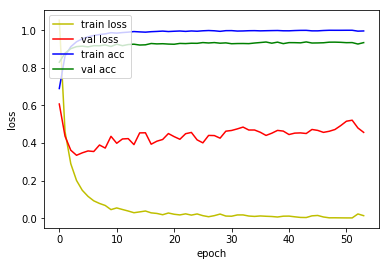

4815/4815 [==============================] - 1s 284us/sample - loss: 0.4196 - acc: 0.8818
Loss: 0.4196270033825471 Accuracy: 0.8818276

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.0744 - acc: 0.6716
Epoch 00001: val_loss improved from inf to 0.61401, saving model to model/checkpoint/2D_CNN_3_conv_2_fcn_no_DO_checkpoint/01-0.6140.hdf5
36805/36805 [==============================] - 16s 444us/sample - loss: 1.0727 - acc: 0.6722 - val_loss: 0.6140 - val_acc: 0.8183
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.4706 - acc: 0.8552
Epoch 00002: val_loss improved from 0.61401 to 0.42423, saving model to model/checkpoint/2D_CNN_3_conv_2_fcn_no_DO_checkpoint/02-0.4242.hdf5
36805/36805 [==============================] - 14s 371us/sample - loss: 0.4705 - acc: 0.8553 - val_loss: 0.4242 - val_acc: 0.8717
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.2961 - a

Epoch 34/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9979
Epoch 00034: val_loss did not improve from 0.30910
36805/36805 [==============================] - 13s 359us/sample - loss: 0.0078 - acc: 0.9979 - val_loss: 0.3878 - val_acc: 0.9397
Epoch 35/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0177 - acc: 0.9955
Epoch 00035: val_loss did not improve from 0.30910
36805/36805 [==============================] - 13s 353us/sample - loss: 0.0177 - acc: 0.9955 - val_loss: 0.4652 - val_acc: 0.9222
Epoch 36/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0152 - acc: 0.9959
Epoch 00036: val_loss did not improve from 0.30910
36805/36805 [==============================] - 13s 355us/sample - loss: 0.0151 - acc: 0.9959 - val_loss: 0.3995 - val_acc: 0.9341
Epoch 37/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0064 - acc: 0.9982
Epoch 00037: val_loss did not improve from 0.30910
36805/36805 [=====

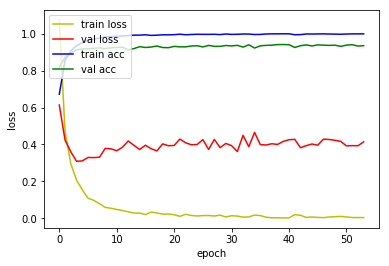

4815/4815 [==============================] - 1s 276us/sample - loss: 0.3984 - acc: 0.8827
Loss: 0.39836548845344616 Accuracy: 0.88265836

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.2451 - acc: 0.6271
Epoch 00001: val_loss improved from inf to 0.72596, saving model to model/checkpoint/2D_CNN_4_conv_1_fcn_no_DO_checkpoint/01-0.7260.hdf5
36805/36805 [==============================] - 15s 419us/sample - loss: 1.2443 - acc: 0.6273 - val_loss: 0.7260 - val_acc: 0.7904
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.6039 - acc: 0.8201
Epoch 00002: val_loss improved from 0.72596 to 0.49134, saving model to model/checkpoint/2D_CNN_4_conv_1_fcn_no_DO_checkpoint/02-0.4913.hdf5
36805/36805 [==============================] - 12s 332us/sample - loss: 0.6038 - acc: 0.8201 - val_loss: 0.4913 - val_acc: 0.8558
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.4184 -

Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9939
Epoch 00028: val_loss did not improve from 0.33986
36805/36805 [==============================] - 12s 314us/sample - loss: 0.0227 - acc: 0.9939 - val_loss: 0.5301 - val_acc: 0.9229
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9911
Epoch 00029: val_loss did not improve from 0.33986
36805/36805 [==============================] - 12s 318us/sample - loss: 0.0324 - acc: 0.9911 - val_loss: 0.5468 - val_acc: 0.9192
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0225 - acc: 0.9939
Epoch 00030: val_loss did not improve from 0.33986
36805/36805 [==============================] - 12s 324us/sample - loss: 0.0225 - acc: 0.9939 - val_loss: 0.5168 - val_acc: 0.9229
Epoch 31/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9928
Epoch 00031: val_loss did not improve from 0.33986
36805/36805 [=====

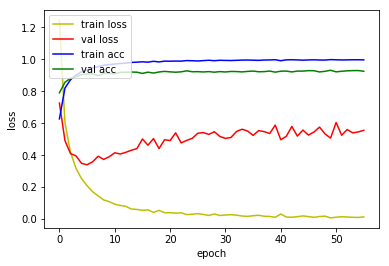

4815/4815 [==============================] - 1s 298us/sample - loss: 0.4441 - acc: 0.8785
Loss: 0.44405080159876575 Accuracy: 0.8785047

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.2222 - acc: 0.6239
Epoch 00001: val_loss improved from inf to 0.69270, saving model to model/checkpoint/2D_CNN_4_conv_2_fcn_no_DO_checkpoint/01-0.6927.hdf5
36805/36805 [==============================] - 16s 448us/sample - loss: 1.2213 - acc: 0.6242 - val_loss: 0.6927 - val_acc: 0.7994
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.5449 - acc: 0.8327
Epoch 00002: val_loss improved from 0.69270 to 0.46000, saving model to model/checkpoint/2D_CNN_4_conv_2_fcn_no_DO_checkpoint/02-0.4600.hdf5
36805/36805 [==============================] - 12s 334us/sample - loss: 0.5447 - acc: 0.8327 - val_loss: 0.4600 - val_acc: 0.8647
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.3781 - 

Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0282 - acc: 0.9920
Epoch 00028: val_loss did not improve from 0.31322
36805/36805 [==============================] - 12s 325us/sample - loss: 0.0281 - acc: 0.9920 - val_loss: 0.4199 - val_acc: 0.9350
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9930
Epoch 00029: val_loss did not improve from 0.31322
36805/36805 [==============================] - 12s 317us/sample - loss: 0.0244 - acc: 0.9930 - val_loss: 0.4146 - val_acc: 0.9294
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9927
Epoch 00030: val_loss did not improve from 0.31322
36805/36805 [==============================] - 12s 326us/sample - loss: 0.0261 - acc: 0.9927 - val_loss: 0.4149 - val_acc: 0.9292
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9937
Epoch 00031: val_loss did not improve from 0.31322
36805/36805 [=====

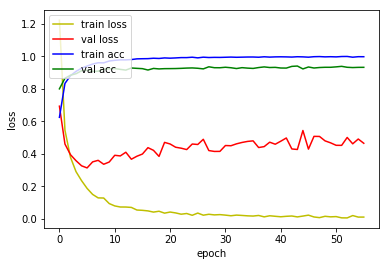

4815/4815 [==============================] - 1s 306us/sample - loss: 0.3905 - acc: 0.8887
Loss: 0.3904607600017005 Accuracy: 0.88868123



In [13]:
for i in range(1, 5):
    for j in range(1, 3):
        model_name = '2D_CNN_{}_conv_{}_fcn_no_DO'.format(i, j)
        model = build_cnn_no_DO(conv_num=i, fcn_num=j)
#         model.summary()
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])
    
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        os.makedirs(model_path, exist_ok=True)
        model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
        checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                       verbose=1, save_best_only=True)

        early_stopping = EarlyStopping(monitor='val_loss', patience=50)
        hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=200, 
                         validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                         callbacks = [checkpointer, early_stopping])

        print()
        print(model_name, 'Model')
        fig, ax = plt.subplots()
        ax.plot(hist.history['loss'], 'y', label='train loss')
        ax.plot(hist.history['val_loss'], 'r', label='val loss')
        ax.plot(hist.history['acc'], 'b', label='train acc')
        ax.plot(hist.history['val_acc'], 'g', label='val acc')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        plt.show()
        
        png_path = 'visualization/learning_curve/'
        filename = model_name+'.png'
        os.makedirs(png_path, exist_ok=True)
        fig.savefig(png_path+filename, transparent=True)
        
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
        model = load_model(model_filename)
        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

In [14]:
for i in range(1, 5):
    for j in range(1, 3):
        model_name = '2D_CNN_{}_conv_{}_fcn_no_DO'.format(i, j)
        print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'
  
        model = load_model(model_filename)
        model.summary()
    
        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

2D_CNN_1_conv_1_fcn_no_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 95, 8)        208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 48, 8)        0         
_________________________________________________________________
flatten (Flatten)            (None, 48768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              49939456  
_________________________________________________________________
dense_1 (Dense)              (None, 16)                16400     
Total params: 49,956,064
Trainable params: 49,956,064
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 1s 299us/sample - loss: 0.6420 - acc: 0.8181
Loss: 0.

4815/4815 [==============================] - 2s 352us/sample - loss: 0.3984 - acc: 0.8827
Loss: 0.39836548845344616 Accuracy: 0.88265836

2D_CNN_4_conv_1_fcn_no_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 253, 95, 8)        208       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 127, 48, 8)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 123, 44, 16)       3216      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 22, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 58, 18, 32)        12832     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 29